# HDE DATA ANALYSIS

## 0 Introduction

<p style="line-height: 1.75;">
In this baseline, I mainly focus on analysing the spatiotemporal patterns of three selected stations shown below: 1 in By Brook river (Middlehill), and 2 in Avon river (Bathford, and Bath). </br>
The flow and rainfall datasets are downloaded and the relationships might exist in each station based on its flow and river level, or, there will probably be relationships across different stations which have geographical combination. </br>
Datasets are from website Hydrology Data Explorer. 

<img src="../prior_images/station_map_2.png" width=1000px height=500px />

## 1 Import and Load Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import math
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.tsa.api import VAR
from tslearn.metrics import cdist_dtw
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram

import warnings
warnings.filterwarnings("ignore")

/opt/miniconda3/envs/conv-seq/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
## 1) Load flow and river level datasets of each station
Bathford_flow = pd.read_csv('Dataset_HDE/Bathford-flow-15min-Qualified.csv')[['dateTime', 'value']]
Middlehill_flow = pd.read_csv('Dataset_HDE/Middlehill-flow-15min-Qualified.csv')[['dateTime', 'value']]
Bathford_level = pd.read_csv('Dataset_HDE/Bathford-level-15min-Qualified.csv')[['dateTime', 'value']]
Middlehill_level = pd.read_csv('Dataset_HDE/Middlehill-level-15min-Qualified.csv')[['dateTime', 'value']]

In [3]:
## 2) Unify
Bathford_flow['dateTime'] = pd.to_datetime(Bathford_flow['dateTime']).sort_values().reset_index(drop=True)
Middlehill_flow['dateTime'] = pd.to_datetime(Middlehill_flow['dateTime']).sort_values().reset_index(drop=True)
Bathford_level['dateTime'] = pd.to_datetime(Bathford_level['dateTime']).sort_values().reset_index(drop=True)
Middlehill_level['dateTime'] = pd.to_datetime(Middlehill_level['dateTime']).sort_values().reset_index(drop=True)

print("Flow datasets loaded successfully.\n")
print("Flow in Bathford station: starts from", Bathford_flow['dateTime'][0], "to", Bathford_flow['dateTime'].iloc[-1], ", total", len(Bathford_flow), "records.")
print("River level in Bathford station: starts from", Bathford_level['dateTime'][0], "to", Bathford_level['dateTime'].iloc[-1], ", total", len(Bathford_level), "records.")
print("Flow in Middlehill station: starts from", Middlehill_flow['dateTime'][0], "to", Middlehill_flow['dateTime'].iloc[-1], ", total", len(Middlehill_flow), "records.")
print("River level in Middlehill station: starts from", Middlehill_level['dateTime'][0], "to", Middlehill_level['dateTime'].iloc[-1], ", total", len(Middlehill_level), "records.")

Flow datasets loaded successfully.

Flow in Bathford station: starts from 1969-10-27 13:00:00 to 2025-11-10 10:00:00 , total 1851156 records.
River level in Bathford station: starts from 1969-10-27 13:00:00 to 2025-11-10 10:15:00 , total 1212985 records.
Flow in Middlehill station: starts from 1981-12-30 13:15:00 to 2025-11-10 10:00:00 , total 1533370 records.
River level in Middlehill station: starts from 1981-12-30 13:15:00 to 2025-11-10 10:15:00 , total 1533371 records.


In [42]:
## 3) Merge flow and RiverLevel datasets based on Date
Bathford_data = pd.merge(Bathford_flow, Bathford_level.iloc[:-1], on='dateTime')
Middlehill_data = pd.merge(Middlehill_flow, Middlehill_level.iloc[:-1], on='dateTime')
print("Merged Flow and RiverLevel datasets successfully.\n")

## 4) Handle missing values by filling with 0
Bathford_data = Bathford_data.fillna(0)
Middlehill_data = Middlehill_data.fillna(0)
df_rainfall = df_rainfall.fillna(0)
print("Filled missing values with 0 successfully.\n")

## 5) Transform numerical columns to float type
Bathford_data.columns = ['Date', 'Flow', 'RiverLevel']
Middlehill_data.columns = ['Date', 'Flow', 'RiverLevel']
Bathford_data['Flow'] = Bathford_data['Flow'].astype(float)
Bathford_data['RiverLevel'] = Bathford_data['RiverLevel'].astype(float)
Middlehill_data['Flow'] = Middlehill_data['Flow'].astype(float)
Middlehill_data['RiverLevel'] = Middlehill_data['RiverLevel'].astype(float)
df_rainfall.columns = ['Date', 'Rainfall']
df_rainfall['Rainfall'] = df_rainfall['Rainfall'].astype(float)
print("Transformed numerical columns to float type successfully.\n")

## 6) Merge rainfall
Bathford_data_rainfall = pd.merge(Bathford_data, df_rainfall, on='Date')
Middlehill_data_rainfall = pd.merge(Middlehill_data, df_rainfall, on='Date')

Merged Flow and RiverLevel datasets successfully.

Filled missing values with 0 successfully.

Transformed numerical columns to float type successfully.



In [44]:
## 6) Set up some variables for later analysis
stations = {
    'Bathford': Bathford_data_rainfall,
    'Middlehill': Middlehill_data_rainfall
}
station_names = list(stations.keys())
num_stations = len(station_names)
print("Prepared data for", num_stations, "stations:", station_names, "\n")

Prepared data for 2 stations: ['Bathford', 'Middlehill'] 



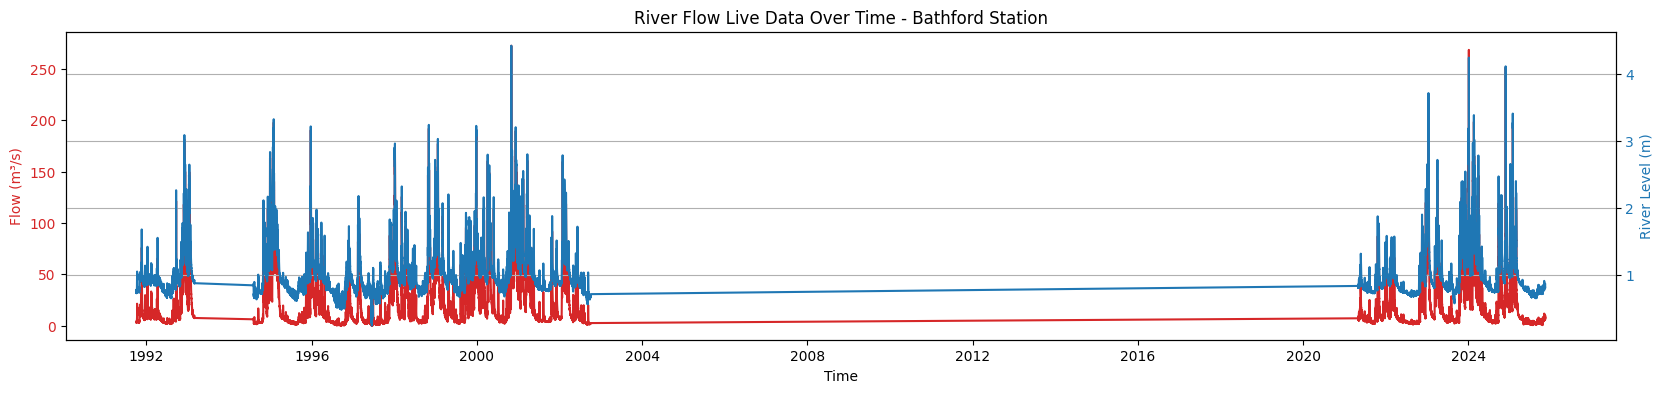

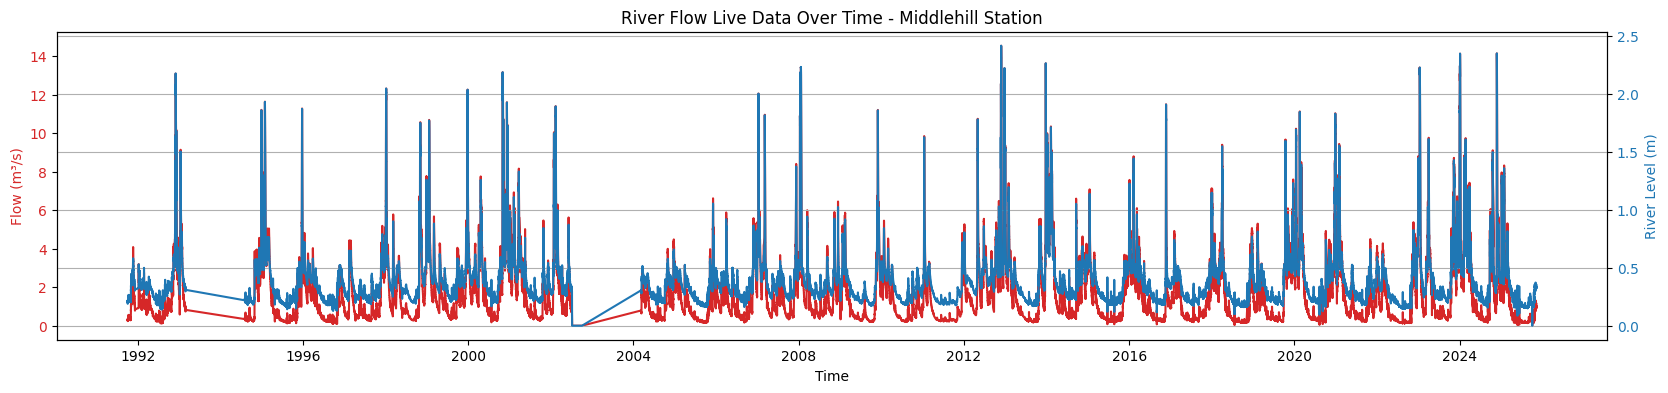

In [45]:
## 7) Visualise flow and River Level data over time
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # plt.figure(figsize=(20, 4))
    fig, ax1 = plt.subplots()

    ax1.figure.set_size_inches(20, 4)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow (m³/s)', color='tab:red')
    ax1.plot(list(df['Date']), list(df['Flow']), color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('River Level (m)', color='tab:blue')
    ax2.plot(list(df['Date']), list(df['RiverLevel']), color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'River Flow Live Data Over Time - {station_name} Station')
    # fig.tight_layout()
    plt.grid()
    plt.show()

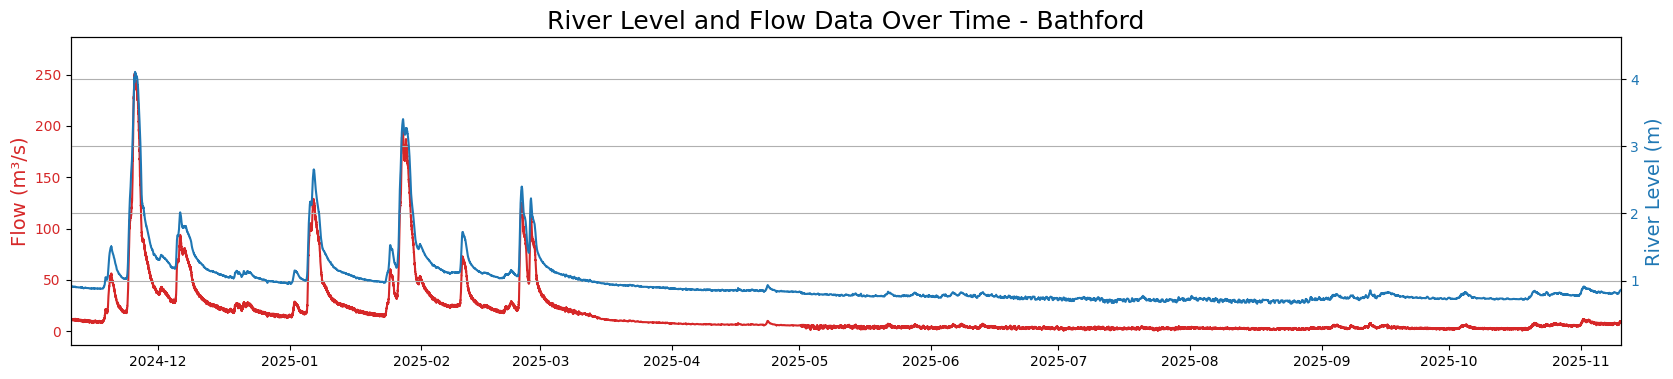

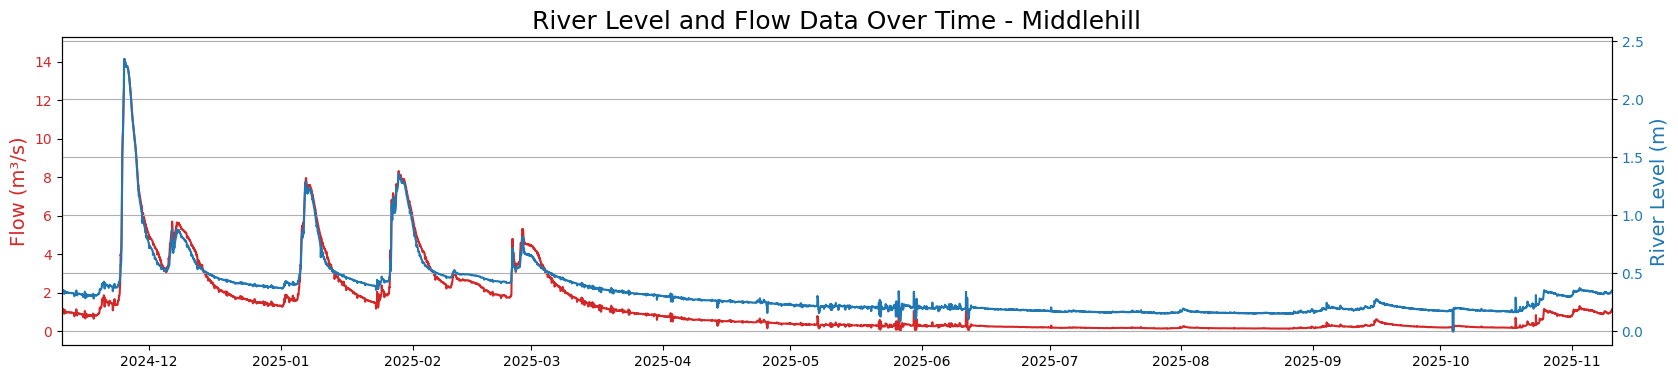

In [18]:
## 8) zoom in to see recent data
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # plt.figure(figsize=(20, 4))
    fig, ax1 = plt.subplots()

    ax1.figure.set_size_inches(20, 4)
    # ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow (m³/s)', color='tab:red', fontsize=14)
    ax1.plot(list(df['Date']), list(df['Flow']), color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('River Level (m)', color='tab:blue', fontsize=14)
    ax2.plot(list(df['Date']), list(df['RiverLevel']), color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax1.set_xlim([df['Date'].iloc[-365*96], df['Date'].iloc[-1]])
    ax2.set_xlim([df['Date'].iloc[-365*96], df['Date'].iloc[-1]])
    plt.title(f'River Level and Flow Data Over Time - {station_name}', fontsize=18)
    # fig.tight_layout()
    plt.grid()
    plt.savefig(f'HDE_outputs/flow_{station_name}.png')
    plt.show()

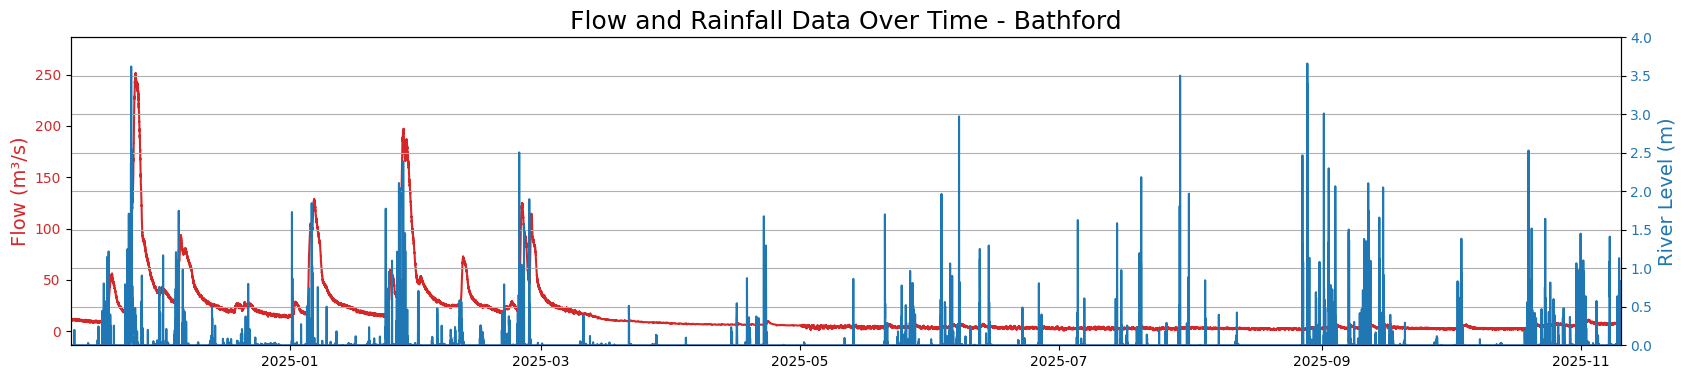

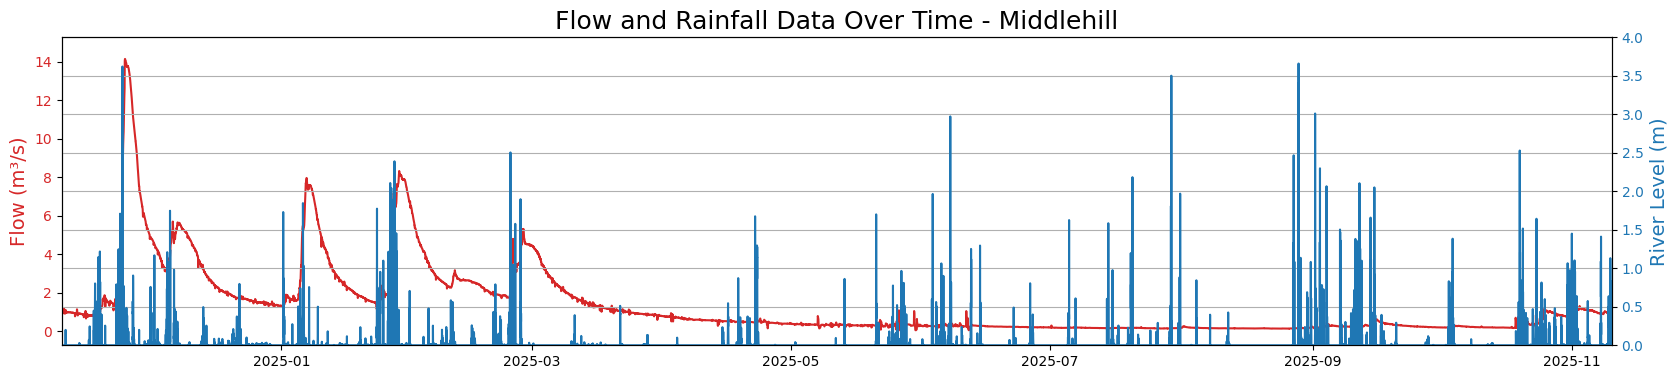

In [52]:
## 8) zoom in to see recent data
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # plt.figure(figsize=(20, 4))
    fig, ax1 = plt.subplots()

    ax1.figure.set_size_inches(20, 4)
    # ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow (m³/s)', color='tab:red', fontsize=14)
    ax1.plot(list(df['Date']), list(df['Flow']), color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('River Level (m)', color='tab:blue', fontsize=14)
    ax2.plot(list(df['Date']), list(df['Rainfall']), color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim([0, 4])

    ax1.set_xlim([df['Date'].iloc[-365*96], df['Date'].iloc[-1]])
    ax2.set_xlim([df['Date'].iloc[-365*96], df['Date'].iloc[-1]])
    plt.title(f'Flow and Rainfall Data Over Time - {station_name}', fontsize=18)
    # fig.tight_layout()
    plt.grid()
    plt.savefig(f'HDE_outputs/flow_rainfall_{station_name}.png')
    plt.show()

## 2 Correlation Analysis of Each Stations

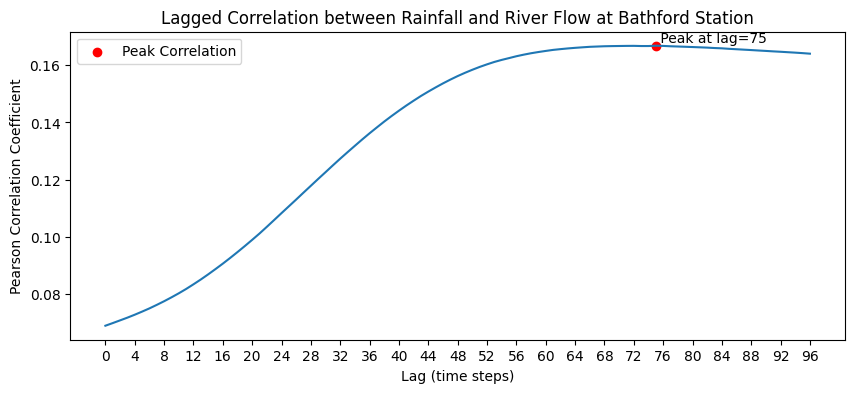

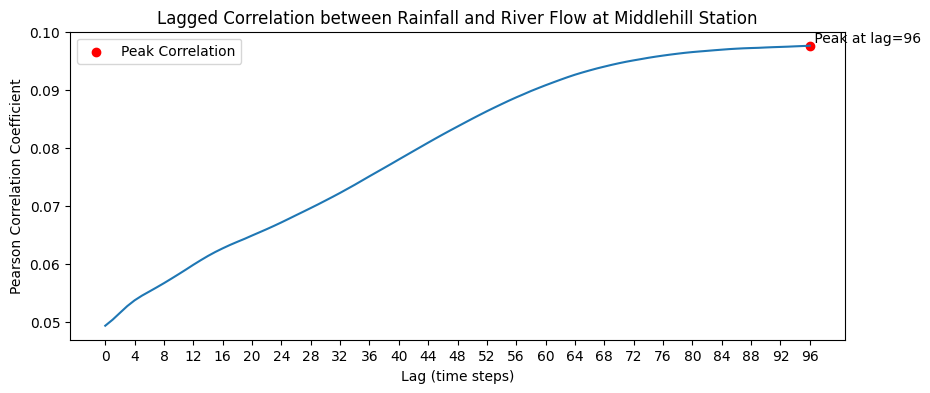

In [49]:
## Calculate the lagged correlation between flow peaks and Rainfall peaks for each station
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # calculate lagged correlation
    max_lag = 4 * 24  # Max lag
    lagged_correlations = []
    for lag in range(max_lag + 1):
        shifted_level = df['Rainfall'].shift(lag)
        valid_indices = shifted_level.dropna().index # df[['Flow', 'Rainfall']].dropna().index
        corr_coef, p_value = pearsonr(df.loc[valid_indices, 'Flow'], shifted_level.loc[valid_indices])
        lagged_correlations.append(corr_coef)
        # print(f"Lag {lag}: Correlation = {corr_coef:.3f}, p-value = {p_value:.3f}")
    plt.figure(figsize=(10, 4))
    plt.plot(range(max_lag + 1), lagged_correlations)
    plt.xticks(range(0, max_lag + 1, 4))
    plt.scatter(np.where(np.array(lagged_correlations) == max(lagged_correlations))[0], 
                [max(lagged_correlations)], color='red', label='Peak Correlation')
    plt.text(np.where(np.array(lagged_correlations) == max(lagged_correlations))[0][0], 
             max(lagged_correlations), 
             f' Peak at lag={np.where(np.array(lagged_correlations) == max(lagged_correlations))[0][0]}',
             fontsize=10, verticalalignment='bottom', horizontalalignment='left')
    plt.legend()
    plt.title(f'Lagged Correlation between Rainfall and River Flow at {station_name} Station')
    plt.xlabel('Lag (time steps)')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.show()

In [31]:
def trans_to_season_map(df):

    df['Month'] = df['Date'].dt.month
    season_name_map = {
        1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
        12: 'Winter'
    }
    
    df['Season'] = df['Month'].map(season_name_map)
    
    season_num_map = {
        1: 4, 2: 4,  # Winter
        3: 1, 4: 1, 5: 1,  # Spring
        6: 2, 7: 2, 8: 2,  # Summer
        9: 3, 10: 3, 11: 3, # Autumn
        12: 4         # Winter
    }
    df['Season_Num'] = df['Month'].map(season_num_map)
    
    return df.dropna(how='all')

In [32]:
Bathford_data = trans_to_season_map(Bathford_data)
Middlehill_data = trans_to_season_map(Middlehill_data)

In [33]:
Bathford_data

,Date,Flow,RiverLevel,Month,Season,Season_Num
0,1969-10-27 13:00:00,3.643,0.765,10,Autumn,3
1,1969-10-27 13:15:00,3.643,0.765,10,Autumn,3
2,1969-10-27 13:30:00,3.668,0.766,10,Autumn,3
3,1969-10-27 13:45:00,3.693,0.767,10,Autumn,3
4,1969-10-27 14:00:00,3.718,0.768,10,Autumn,3
...,...,...,...,...,...,...
1212979,2025-11-10 09:00:00,9.417,0.856,11,Autumn,3
1212980,2025-11-10 09:15:00,9.249,0.858,11,Autumn,3
1212981,2025-11-10 09:30:00,9.612,0.859,11,Autumn,3
1212982,2025-11-10 09:45:00,9.257,0.861,11,Autumn,3


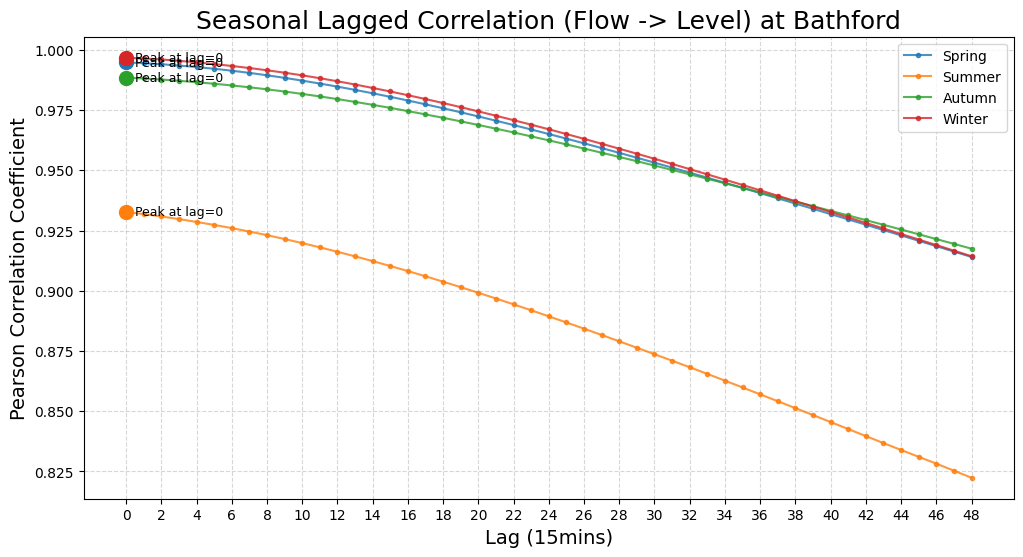

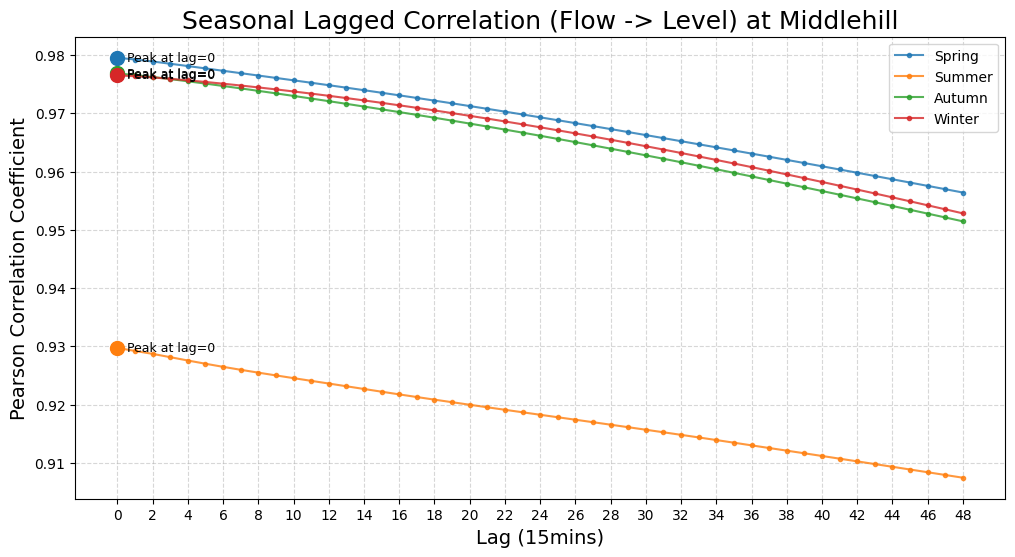

In [35]:
for i in range(num_stations):
    station_name = station_names[i]
    df_original = trans_to_season_map(stations[station_name].copy()) 

    max_lag = 48  # Max lag of 1/2 day - 12h 
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

    lagged_corr_by_season = {season: [] for season in seasons}

    for season in seasons:
        df_season = df_original[df_original['Season'] == season]
        
        for lag in range(max_lag + 1):
            shifted_level = df_season['RiverLevel'].shift(lag)

            valid_indices = shifted_level.dropna().index

            flow_data = df_season.loc[valid_indices, 'Flow']
            level_data = shifted_level.loc[valid_indices]

            if len(flow_data) < 2: 
                corr_coef = np.nan
            else:
                corr_coef, p_value = pearsonr(flow_data, level_data)
                
            lagged_corr_by_season[season].append(corr_coef)

    plt.figure(figsize=(12, 6))
    
    for season in seasons:
        correlations = lagged_corr_by_season[season]

        if all(np.isnan(correlations)):
            print(f"Skipped: there is no effective relevant data at {station_name} in {season}.")
            continue
            
        plt.plot(range(max_lag + 1), correlations, label=f'{season}', marker='.', alpha=0.8)
        
        peak_corr = np.nanmax(correlations)
        peak_lag_idx = np.nanargmax(correlations)
        
        plt.scatter(peak_lag_idx, peak_corr, s=100, zorder=5)
        plt.text(peak_lag_idx + 0.3, peak_corr, 
                 f' Peak at lag={peak_lag_idx}', 
                 fontsize=9, verticalalignment='center')

    plt.title(f'Seasonal Lagged Correlation (Flow -> Level) at {station_name}', fontsize=18)
    plt.xlabel('Lag (15mins)', fontsize=14)
    plt.ylabel('Pearson Correlation Coefficient', fontsize=14)
    plt.xticks(range(0, max_lag + 1, 2))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(f'HDE_outputs/PCC_{station_name}.png')
    plt.show()

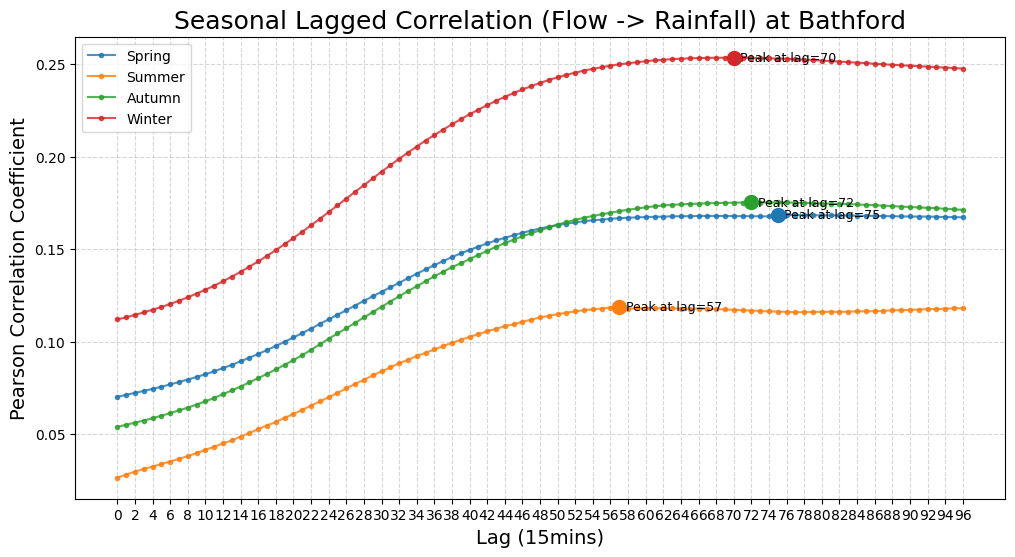

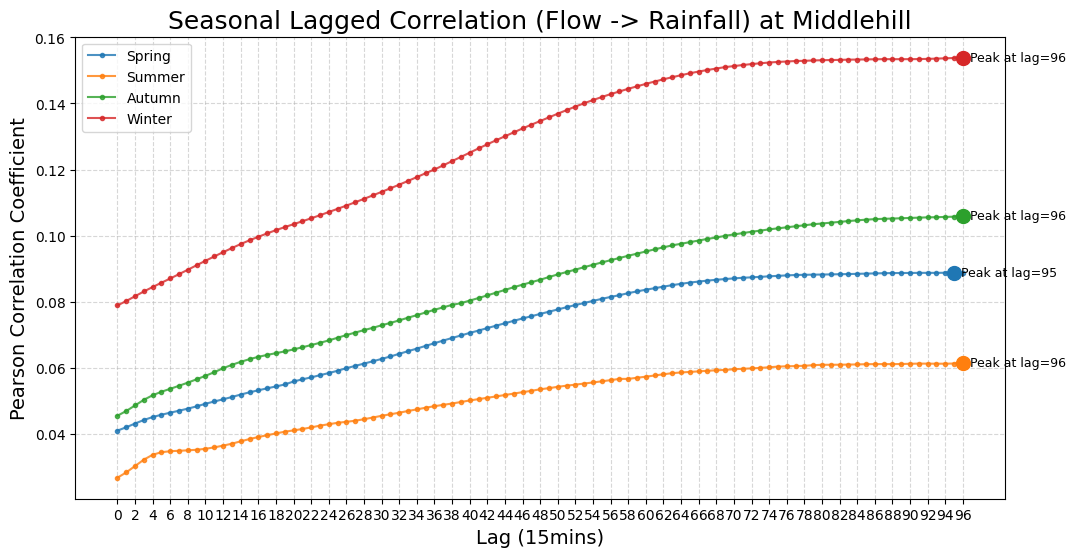

In [56]:
for i in range(num_stations):
    station_name = station_names[i]
    df_original = trans_to_season_map(stations[station_name].copy()) 

    max_lag = 4 * 24  # Max lag of 24h 
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

    lagged_corr_by_season = {season: [] for season in seasons}

    for season in seasons:
        df_season = df_original[df_original['Season'] == season]
        
        for lag in range(max_lag + 1):
            shifted_level = df_season['Rainfall'].shift(lag)

            valid_indices = shifted_level.dropna().index

            flow_data = df_season.loc[valid_indices, 'Flow']
            level_data = shifted_level.loc[valid_indices]

            if len(flow_data) < 2: 
                corr_coef = np.nan
            else:
                corr_coef, p_value = pearsonr(flow_data, level_data)
                
            lagged_corr_by_season[season].append(corr_coef)

    plt.figure(figsize=(12, 6))
    
    for season in seasons:
        correlations = lagged_corr_by_season[season]

        if all(np.isnan(correlations)):
            print(f"Skipped: there is no effective relevant data at {station_name} in {season}.")
            continue
            
        plt.plot(range(max_lag + 1), correlations, label=f'{season}', marker='.', alpha=0.8)
        
        peak_corr = np.nanmax(correlations)
        peak_lag_idx = np.nanargmax(correlations)
        
        plt.scatter(peak_lag_idx, peak_corr, s=100, zorder=5)
        plt.text(peak_lag_idx + 0.3, peak_corr, 
                 f' Peak at lag={peak_lag_idx}', 
                 fontsize=9, verticalalignment='center')

    plt.title(f'Seasonal Lagged Correlation (Flow -> Rainfall) at {station_name}', fontsize=18)
    plt.xlabel('Lag (15mins)', fontsize=14)
    plt.ylabel('Pearson Correlation Coefficient', fontsize=14)
    plt.xticks(range(0, max_lag + 1, 2))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(f'HDE_outputs/PCC_rainfall_{station_name}.png')
    plt.show()